In [1]:
import os

import fitsio
import numpy as np
import pylab as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table

import sep
import tractor

from astrometry.util.fits import fits_table
from astrometry.util.util import wcs_pv2sip_hdr

from tractor import NullWCS
from tractor.galaxy import *
from tractor.sersic import *
from tractor.psf import *
from tractor.ellipses import *

In [2]:
def make_plot(tim, mod, filename='tractor_test.png'):
    image = tim.getImage()
    
    # imshow arguments for images
    mn, mx = np.percentile(image, [25,99])
    ima = dict(interpolation='nearest', origin='lower',
               cmap='gray', vmin=mn, vmax=mx)
    
    # imshow arguments for chi images
    chia = dict(interpolation='nearest', origin='lower',
               cmap='gray', vmin=-5, vmax=+5)
    
    plt.clf()
    plt.subplot(131)
    plt.imshow(image, **ima)
    plt.xticks([]); plt.yticks([])
    plt.title('Data')
    
    plt.subplot(132)
    plt.imshow(mod, **ima)
    plt.xticks([]); plt.yticks([])
    plt.title('Model')
    
    plt.subplot(133)
    plt.imshow(image - mod, **ima)
    plt.xticks([]); plt.yticks([])
    plt.title('Residual')
    
    plt.show()
    plt.savefig(filename)

# Based on Dane's notebook

In [7]:
#open fits files

galaxy_dir = os.path.abspath('tractor') + '/26_tractor_ready'
print(galaxy_dir)

img_data = fits.open(os.path.join(galaxy_dir, 'img_data_crop_26.fits'))[0].data
sig_data = fits.open(os.path.join(galaxy_dir, 'sig_data_crop_26.fits'))[0].data

psf_data = fits.open(os.path.join(galaxy_dir, 'psf_data_crop_26.fits'))[0].data
psf_obj = PixelizedPSF(psf_data, Lorder=5)
#psf_obj = NCircularGaussianPSF([2.5], [1.])

obj_cat = Table.read(os.path.join(galaxy_dir, 'tractor_26.fits'))

invvar_data = (1.0 / (sig_data ** 2.0))
#invvar_data[bad_data > 0] = np.nan

wcs_obj = NullWCS(pixscale=0.168)

/Users/danecross/Desktop/2DMassiveGals/2DMassiveGalaxies/tractor/26_tractor_ready


In [8]:
tim = tractor.Image(data=img_data,
                    invvar=invvar_data,
                    psf=psf_obj,
                    wcs=wcs_obj,
                    sky=tractor.ConstantSky(0.0),
                    photocal=tractor.NullPhotoCal(), 
            )

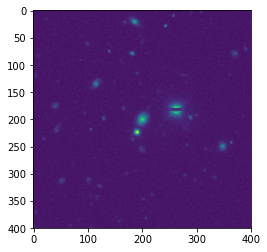

In [9]:
plt.imshow(np.arcsinh(tim.getImage()))
plt.show()

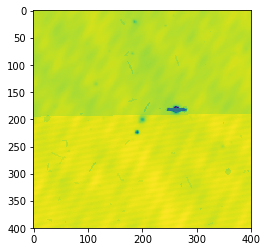

In [10]:
plt.imshow(np.arcsinh(tim.getInvvar()))
plt.show()

In [11]:
sources=[]

for obj in obj_cat:
    # if the object is a point source, add it as such
    if obj['point_source'] > 0.0:
        sources.append(tractor.PointSource(tractor.PixPos(obj['x'], obj['y']),
                                           tractor.Flux(obj['flux'])) )
    else:
        sources.append(tractor.DevGalaxy(tractor.PixPos(obj['x'], obj['y']),
                                         tractor.Flux(obj['flux']),
                                         GalaxyShape(obj['a'] / 2.0, 
                                                     (obj['b'] / obj['a']),
                                                     (180.0 - obj['theta'] * 180.0 / np.pi))))

In [12]:
trac_obj = Tractor([tim], sources)

trac_mod = trac_obj.getModelImage(0, minsb=0., srcs=sources)

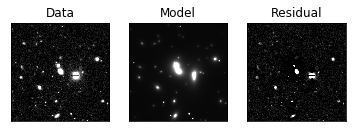

In [13]:
make_plot(tim, trac_mod, filename='tractor_26_init.png')

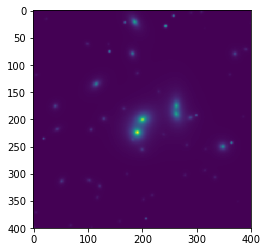

In [14]:
plt.imshow(np.arcsinh(trac_mod))
plt.show()

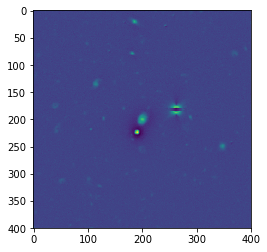

In [15]:
plt.imshow(np.arcsinh(img_data - trac_mod))
plt.show()

In [16]:
# We don't want to fit for any of the image calibration properties:
trac_obj.freezeParam('images')

In [17]:
trac_obj.optimize_loop()

patchx is None:
   DevGalaxy at pixel (401.43, 22.25) with Flux: 4.6679 and Galaxy Shape: re=-0.76, ab=-0.21, phi=250.8
  stepping galaxy shape ab
  stepped 1.0
  to -0.211768717988
patchx is None:
   DevGalaxy at pixel (401.43, 22.25) with Flux: 4.6679 and Galaxy Shape: re=-0.76, ab=-0.21, phi=250.8
  stepping galaxy shape phi
  stepped 1.0
  to 250.760157333
patchx is None:
   DevGalaxy at pixel (107.03, 400.55) with Flux: 7.2265 and Galaxy Shape: re=-1.86, ab=1.77, phi=152.1
  stepping galaxy shape re
  stepped 1.0
  to -1.85724574181
patchx is None:
   DevGalaxy at pixel (107.03, 400.55) with Flux: 7.2265 and Galaxy Shape: re=-1.86, ab=1.77, phi=152.1
  stepping galaxy shape ab
  stepped 1.0
  to 1.77226313334
patchx is None:
   DevGalaxy at pixel (107.03, 400.55) with Flux: 7.2265 and Galaxy Shape: re=-1.86, ab=1.77, phi=152.1
  stepping galaxy shape phi
  stepped 1.0
  to 152.125050914


IndexError: index 315 is out of bounds for axis 1 with size 315

In [ ]:
trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources)

plt.imshow(np.arcsinh(trac_mod_opt))
plt.show()

In [ ]:
trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources)

plt.imshow(np.arcsinh(img_data - trac_mod_opt))
plt.show()